<h1 align=center>PRÁCTICA DEL MÓDULO DE NLP</h1>

<h3 align=center>ALUMNO: David Jiménez Vicente</h3>

<h2 align=center>Notebook 1 : Descarga y EDA</h2>

En este proyecto final vamos a realizar un Análisis de Sentimiento sobre reviews de una categoría de productos de Amazon.

El proyecto estará dividido en 4 Notebooks diferentes, uno por cada etapa:  
1.- Descarga de datos y EDA.  
2.- Preprocesado de los datos.  
3.- Entrenamiento y testeo de modelos.  
4.- Reporte de métricas y conclusiones.  
  
Este es el primer notebook del proyecto, dedicado a la obtención de los datos y el EDA.

---

<h3 align=center><i>Etapa 1: Obtención de los datos</i></h3>

Primero impoortamos las librerías necesarias

In [1]:
import random
import numpy as np
import pandas as pd

from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración
import unicodedata # Preprocesado
import re # Preprocesado
from num2words import num2words # Preprocesado

from nltk import RegexpTokenizer # Preprocesado
from nltk.corpus import stopwords # Preprocesado
from nltk.stem import WordNetLemmatizer # Preprocesado

import matplotlib.pyplot as plt # Dibujo
from wordcloud import WordCloud, STOPWORDS # Dibujo

Vamos a descargar del site los datos que necesitamos. Analizaremos un corpus de reviews sobre Instrumentos musicales.

In [2]:
import gzip
import pandas as pd
import json

!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Musical_Instruments.json.gz

def parse(path):
    with gzip.open(path, 'rb') as g:
        for l in g:
            yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Musical_Instruments.json.gz')


Vamos a hacer algo de EDA cuantitativo:

In [3]:
df.shape

(1512530, 12)

In [4]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,90,False,"08 9, 2004",AXHY24HWOF184,0470536454,{'Format:': ' Paperback'},Bendy,Crocheting for Dummies by Karen Manthey & Susa...,Terrific Book for Learning the Art of Crochet,1092009600,NaN
1,4.0,2,True,"04 6, 2017",A29OWR79AM796H,0470536454,{'Format:': ' Hardcover'},Amazon Customer,Very helpful...,Four Stars,1491436800,NaN
2,5.0,NaN,True,"03 14, 2017",AUPWU27A7X5F6,0470536454,{'Format:': ' Paperback'},Amazon Customer,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,Five Stars,1489449600,NaN
3,4.0,NaN,True,"02 14, 2017",A1N69A47D4JO6K,0470536454,{'Format:': ' Paperback'},Christopher Burnett,My girlfriend use quite often,Four Stars,1487030400,NaN
4,5.0,NaN,True,"01 29, 2017",AHTIQUMVCGBFJ,0470536454,{'Format:': ' Paperback'},Amazon Customer,Arrived as described. Very happy.,Very happy.,1485648000,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1512530 entries, 0 to 1512529
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1512530 non-null  float64
 1   vote            243948 non-null   object 
 2   verified        1512530 non-null  bool   
 3   reviewTime      1512530 non-null  object 
 4   reviewerID      1512530 non-null  object 
 5   asin            1512530 non-null  object 
 6   style           672538 non-null   object 
 7   reviewerName    1512380 non-null  object 
 8   reviewText      1511675 non-null  object 
 9   summary         1512150 non-null  object 
 10  unixReviewTime  1512530 non-null  int64  
 11  image           30165 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 139.9+ MB


---

<h3 align=center><i>Etapa 2: Limpieza y EDA</i></h3>

Lo primero que vemos es que la clasificación sentimental está contenida en la columna "overall", con puntuaciones desde el 0 al 5. Todas las filas tienen valoración.  
Luego, hay un par de columnas que nos dan información sobre las opiniones que han llevado a la valoración contenida en el campo "overall", que podrían darnos nuestras features: "reviewText" y "summary".  
Algo que tambiñén averiguamos es que en la coumna "style" aparecen características de productos que no tienen nada que ver con la categoría analizada, pertenecientes a libros, teléfonos móviles, etc..., por lo que voy a usar esa columna para hacer un primer filtrado de aquellas filas que no pertenecen (a primera vista de esta columna "style") a la categoría que estamos analizando.  
Por lo tanto, para empezar nos quedaremos sólo con las columnas aquí descritas:

In [6]:
df = df[["reviewText", "summary", "style", "overall"]]

In [7]:
df.head()

,reviewText,summary,style,overall
0,Crocheting for Dummies by Karen Manthey & Susa...,Terrific Book for Learning the Art of Crochet,{'Format:': ' Paperback'},5.0
1,Very helpful...,Four Stars,{'Format:': ' Hardcover'},4.0
2,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,Five Stars,{'Format:': ' Paperback'},5.0
3,My girlfriend use quite often,Four Stars,{'Format:': ' Paperback'},4.0
4,Arrived as described. Very happy.,Very happy.,{'Format:': ' Paperback'},5.0


A continuación echaré un vistazo de 200 en 200 a los valores que hay en la columna style para saber qué filas voy a eliminar en base a la descripción de su estilo. Seguramente el filtrado no será perfecto, pero podré quitar las que más evidentemente no corresponden con nuestra categoría de instrumentos musicales.  
A continuación pongo la revisión de los 50 primeros estilos para ilustrar el método de revisión, pero por limpieza del documento no pondré más aunque sí los realizaré en otro chunck de código que no incluiré.

In [8]:
clases = []
for i in df["style"]:
    if i not in clases and pd.notnull(i):
        clases.append(i)

In [9]:
clases[:50]

[{'Format:': ' Paperback'},
 {'Format:': ' Hardcover'},
 {'Format:': ' Kindle Edition'},
 {'Format:': ' Sheet music'},
 {'Format:': ' Misc. Supplies'},
 {'Format:': ' Electronics'},
 {'Format:': ' Mass Market Paperback'},
 {'style:': ' K10 Speaker'},
 {'style:': ' K10 Yoke Mount Kit'},
 {'Color:': ' Black'},
 {'Color:': ' Mahogany'},
 {'Color:': ' White'},
 {'Style:': ' Compact Sustain Pedal'},
 {'Style:': ' Volume Expression Pedal'},
 {'Style:': ' Assignable Sustain Pedal'},
 {'Style:': ' Sustain Pedal with Half-Pedaling'},
 {'Product Packaging:': ' Standard Packaging'},
 {'Color:': ' Surf Green'},
 {'Size:': ' 10 Feet'},
 {'Size:': ' 5 Feet'},
 {'Color:': ' Lake Placid Blue'},
 {'Color:': ' Candy Apple Red'},
 {'Size:': ' 15 Feet'},
 {'Size:': ' 20 Feet'},
 {'Size:': ' 3 Feet'},
 {'Size:': ' 25 Feet'},
 {'Size:': ' 1 Foot'},
 {'Size:': ' 50 Feet'},
 {'Length:': ' 10 feet'},
 {'Size:': ' 5 feet'},
 {'Size:': ' 10 feet'},
 {'Length:': ' 15 feet'},
 {'Length:': ' 25 feet'},
 {'Length:':

In [10]:
estilos_a_eliminar = [' Paperback', ' Hardcover', ' Kindle Edition', ' iphone 6/6s 4.7 inch gold', ' iphone 6/6s', ' iphone 5/5s/se', ' iphone 6 plus/6s plus']

In [11]:
for idx, j in df["style"].items():
    if isinstance(j, dict):
        if any(value in estilos_a_eliminar for value in j.values()):
            df = df.drop(idx)

In [12]:
df

,reviewText,summary,style,overall
95,Easy to read/understand,Five Stars,NaN,5.0
147,I took a crochet for beginners class where I ...,"Take a Crochet 101 class,then get this book.",NaN,5.0
174,Very descriptive and helpful! Isn't confusing ...,Love it!,NaN,5.0
231,"For the last few years, I have been studying J...",A Unique Perspective on the Creative Process,NaN,5.0
232,What an amazing book! I'm so impressed with R...,Required reading for any fan of music or aspir...,NaN,5.0
...,...,...,...,...
1512525,Hard to believe anyone will play their prized ...,Easy to install and does the job,{'Color:': ' Black (2 Pack)'},5.0
1512526,"Straplocks installed nicely, good fitment on m...",Worth.,{'Color:': ' Black (2 Pack)'},4.0
1512527,Great Product,Great Product,{'Color:': ' Black (2 Pack)'},5.0
1512528,I honestly expected these to be cheap pieces o...,A pleasant surprise,{'Color:': ' Black (2 Pack)'},5.0


Siguen quedando referencias a otras categoría como podemos ver en las primeras filas restantes. Ahora eliminaré las filas cuyo campo summary o reviewText contengan algunas palabras clave como "book" o "read".  
Pero antes, eliminaré las filas con NaNs y eliminaré la columna "style" que ya no nos vale.

In [13]:
df = df[~df["summary"].isna()]

In [14]:
df = df[~df["reviewText"].isna()]

In [15]:
df = df.drop("style", axis=1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1510914 entries, 95 to 1512529
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   reviewText  1510914 non-null  object 
 1   summary     1510914 non-null  object 
 2   overall     1510914 non-null  float64
dtypes: float64(1), object(2)
memory usage: 46.1+ MB


In [17]:
df = df[~df["summary"].str.contains("book")]

In [18]:
df = df[~df["summary"].str.contains("read")]

In [19]:
df = df[~df["reviewText"].str.contains("book")]

In [20]:
df = df[~df["reviewText"].str.contains("read")]

In [21]:
df = df[~df["reviewText"].str.contains("crochet")]

In [22]:
df.shape

(1429398, 3)

---

<h3 align=center><i>Etapa 3: Soluciones</i></h3>

#### 1.- Averigüemos la distribución de las reviews por número de estrellas: ·····················································

Primero, una gráfica de barras:

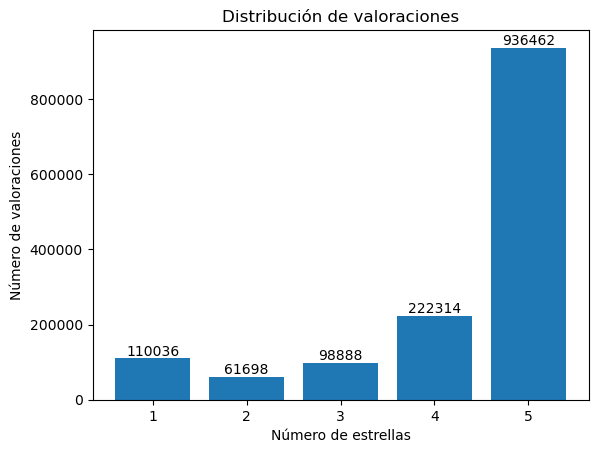

In [23]:
barras = plt.bar(sorted(df.overall.unique()), df.overall.value_counts().sort_index())
plt.bar_label(barras)
plt.title("Distribución de valoraciones")
plt.xlabel("Número de estrellas")
plt.ylabel("Número de valoraciones")
plt.show()

Comprobemos las sumas de cada valoración:

In [24]:
df.overall.value_counts().sort_index()

overall
1.0    110036
2.0     61698
3.0     98888
4.0    222314
5.0    936462
Name: count, dtype: int64

#### 2.- Contemos el número de reviews positivas y negativas: ····································································

Establecemos desde ahora los valores de valoración negativa: 1, 2 y 3 estrellas, y los valores de valoración positiva: 4 y 5 estrellas.

In [25]:
print(f"El número de reviews negativas (de 1 a 3 estrellas) es de {len(df[df.overall <= 3])}")
print(f"El número de reviews positivas (de 4 a 5 estrellas) es de {len(df[df.overall >= 4])}")

El número de reviews negativas (de 1 a 3 estrellas) es de 270622
El número de reviews positivas (de 4 a 5 estrellas) es de 1158776


#### 3.- Análisis del vocabulario ············································································································

Dado que las dos columnas "reviewText" y "summary" contienen información útil para lel análisis de sentimiento, las juntaré en una sola columna para juntar sus potenciales de predicción.

In [26]:
df_joint = df.copy()

In [27]:
df_joint["review"] = df["reviewText"] + " " + df["summary"]

In [28]:
df_joint = df_joint.drop(["reviewText", "summary"], axis=1)
df_joint = df_joint.reset_index(drop=True)
df_joint

,overall,review
0,4.0,"I hesitated at first, but nabbed the kit on a ..."
1,1.0,Plain and simple...some of the frets are not p...
2,5.0,"she loved it, won't stop playing Five Stars"
3,5.0,Thank you Five Stars
4,5.0,I ordered this ukulele kit for my granddaughte...
...,...,...
1429393,5.0,Hard to believe anyone will play their prized ...
1429394,4.0,"Straplocks installed nicely, good fitment on m..."
1429395,5.0,Great Product Great Product
1429396,5.0,I honestly expected these to be cheap pieces o...


Ahora generaremos un Word Cloud de todo el corpus.  
Primero generaré una nube de sólo el campo "reviewText":  


In [29]:
# Primero juntamos todas las palabras en un solo string:
review = []
for i,j in df["reviewText"].items():
    for z in j.split():
        review.append(z + " ")
        
# Y ahora unimos todas las palabras de la lista d eforma inmediata con .join() en un solo string        
one_string = "".join(review)

# Y compruebo el resultado
one_string[:200]

'I hesitated at first, but nabbed the kit on a lightning deal. The uke is pretty easy to learn, even at 30 years old with little music education. The cd and dvd are easy to follow along with. I give fo'

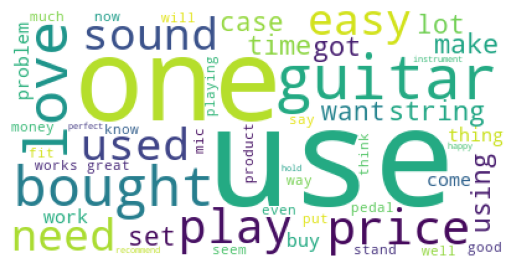

In [30]:
# Ahora la nube de palabras:
wordcloud = WordCloud(background_color = "white", max_words = 50).generate(one_string)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Ahora generaré una nube con los dos campos descriptivos fundidos en uno solo, para ver el cambio en la importancia de las palabras:

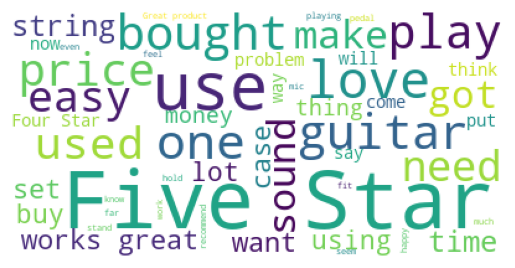

In [31]:
review2 = []
for i,j in df_joint["review"].items():
    for z in j.split():
        review2.append(z + " ")
        
one_string2 = "".join(review2)

wordcloud2 = WordCloud(background_color = "white", max_words = 50).generate(one_string2)
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

El resultado cambia muchísimo. El campo "summary" resume lo más importante de la idea tras la valoración, y "reviewText" detalles sobre las circunstancias de dicha valoración, es decir, su contexto. Por lo tanto, usaré los dos campos fusionados en uno para el modelo.  
Evidentemente, hace falta mucho preprocesado y normalización todavía, que realizaremos en el siguiente notebook, el número 2.

Ahora haremos un wordcloud para el dataset combinado, separando por sentimientos con 1, 2 y 3 estrellas y luego con 4 y 5.

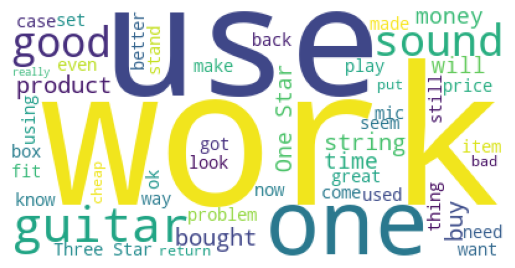

In [32]:
negs = [1.,2.,3.]
poss = [4.,5.]

df_negs = df_joint[(df_joint["overall"] == 1.0) | (df_joint["overall"] == 2.0) | (df_joint["overall"] == 3.0)]
df_poss = df_joint[(df_joint["overall"] == 4.0) | (df_joint["overall"] == 5.0)]

review_neg = []

for i,j in df_negs["review"].items():
    for z in j.split():
        review_neg.append(z + " ")
        
one_string_neg = "".join(review_neg)

wordcloud_neg = WordCloud(background_color = "white", max_words = 50).generate(one_string_neg)
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.show()

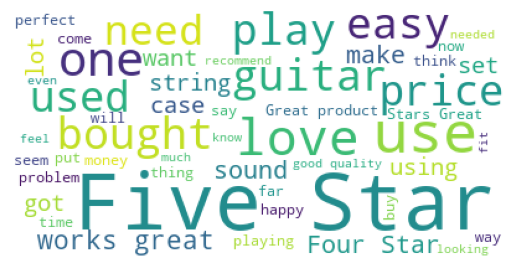

In [33]:
review_pos = []

for i,j in df_poss["review"].items():
    for z in j.split():
        review_pos.append(z + " ")
        
one_string_pos = "".join(review_pos)

wordcloud_pos = WordCloud(background_color = "white", max_words = 50).generate(one_string_pos)
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.show()

Por supuesto, vemos palabras que no van a aportar información para la vcaloración, ya que están bastante presentes en ambos casos, como "guitar". Haciendo un conteo de las palabras más presentes en ambos splits de filas, todas aquellas que coincidan como muy repetidas en ambos a la vez, habrá que quitarlas en la fase de preporcessing.

A continuación, vamos a destilar el vocabulario para hallar una cardinalidad aproximada antes del preprocesamiento completo:

In [34]:
words = set(review2)
len(words)

838449

In [35]:
to_delete = "href"
words = [i for i in words if to_delete not in i]
to_delete = "value="
words = [i for i in words if to_delete not in i]
to_delete = "<"
words = [i for i in words if to_delete not in i]
to_delete = "id="
words = [i for i in words if to_delete not in i]
to_delete = "http"
words = [i for i in words if to_delete not in i]
to_delete = "="
words = [i for i in words if to_delete not in i]
to_delete = "'s"
words = [i for i in words if to_delete not in i]
to_delete = "'n"
words = [i for i in words if to_delete not in i]

In [36]:
print(f"La cardinalidad del vocabulario de palabrás únicas antes del preprocesado es {len(words)}")

La cardinalidad del vocabulario de palabrás únicas antes del preprocesado es 798994


Ahora veremos las palabras más frecuentes para las valoraciones negativas:

In [37]:
neg_counter = Counter(one_string_neg.lower().split())
neg_common = neg_counter.most_common(10)
neg_common

[('the', 821002),
 ('i', 450957),
 ('a', 427484),
 ('to', 394864),
 ('it', 374097),
 ('and', 369023),
 ('is', 233826),
 ('of', 220465),
 ('for', 219651),
 ('not', 215601)]

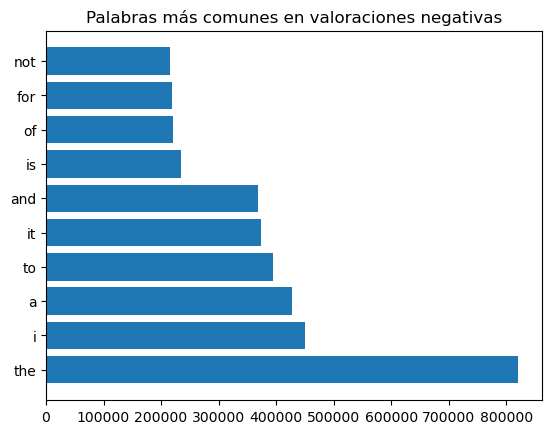

In [38]:
plot_neg = pd.DataFrame(neg_common, columns=["word", "frequency"])
plot_neg
plt.barh(plot_neg.word, plot_neg.frequency)
plt.title("Palabras más comunes en valoraciones negativas")
plt.show()

... y para las positivas:

In [39]:
pos_counter = Counter(one_string_pos.lower().split())
pos_common = pos_counter.most_common(10)
pos_common

[('the', 2301952),
 ('and', 1490904),
 ('a', 1465466),
 ('i', 1407954),
 ('to', 1183549),
 ('it', 1025468),
 ('for', 925908),
 ('is', 801524),
 ('this', 726237),
 ('of', 628483)]

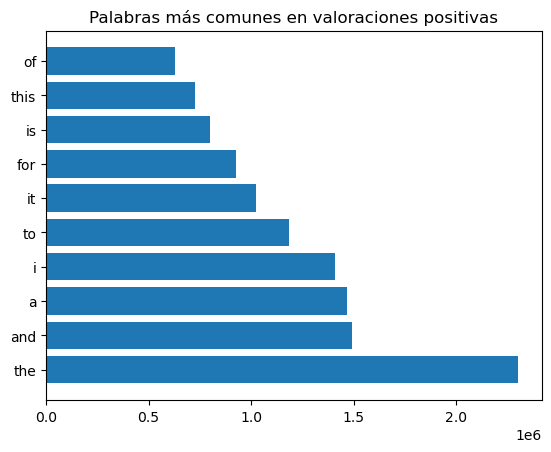

In [40]:
plot_pos = pd.DataFrame(pos_common, columns=["word", "frequency"])
plot_pos
plt.barh(plot_pos.word, plot_pos.frequency)
plt.title("Palabras más comunes en valoraciones positivas")
plt.show()

Se evidencia una vez más la necesidad de realizar una buena normalización y uso de stopwords durante el posterior preprocesado, ya que no sacamos nada de información acerca de la temática de las reviews, ni siquiera de que se está hablando de compras realizadas.

Ahora revisaremos los trigramas más frecuentes:

In [41]:
# Primero creamos los trigramas para ambas categorías
neg_trigrams_ = list(ngrams(one_string_neg.lower().split(), 3))
pos_trigrams_ = list(ngrams(one_string_pos.lower().split(), 3))

In [42]:
# Revisamos los primeros resultados de los trigramas de valoración negativa
neg_trigrams_[:10]

[('plain', 'and', 'simple...some'),
 ('and', 'simple...some', 'of'),
 ('simple...some', 'of', 'the'),
 ('of', 'the', 'frets'),
 ('the', 'frets', 'are'),
 ('frets', 'are', 'not'),
 ('are', 'not', 'placed'),
 ('not', 'placed', 'properly'),
 ('placed', 'properly', 'so'),
 ('properly', 'so', 'the')]

In [43]:
# Y ahora de los positivos
pos_trigrams_[:10]

[('i', 'hesitated', 'at'),
 ('hesitated', 'at', 'first,'),
 ('at', 'first,', 'but'),
 ('first,', 'but', 'nabbed'),
 ('but', 'nabbed', 'the'),
 ('nabbed', 'the', 'kit'),
 ('the', 'kit', 'on'),
 ('kit', 'on', 'a'),
 ('on', 'a', 'lightning'),
 ('a', 'lightning', 'deal.')]

In [44]:
# Y ahora sacamos los trigramas más comunes y las visualizamos: 
neg_tg_freq = FreqDist(neg_trigrams_)
pos_tg_freq = FreqDist(pos_trigrams_)

Trigramas más frecuentes para valoraciones negativas:

In [45]:
neg_tg_freq.most_common(10)

[(('i', 'had', 'to'), 7516),
 (('this', 'is', 'a'), 7431),
 (('out', 'of', 'the'), 7397),
 (('get', 'what', 'you'), 7357),
 (('what', 'you', 'pay'), 7251),
 (('one', 'of', 'the'), 7150),
 (('i', 'bought', 'this'), 7052),
 (('a', 'lot', 'of'), 6289),
 (('you', 'get', 'what'), 6134),
 (('for', 'the', 'price'), 5125)]

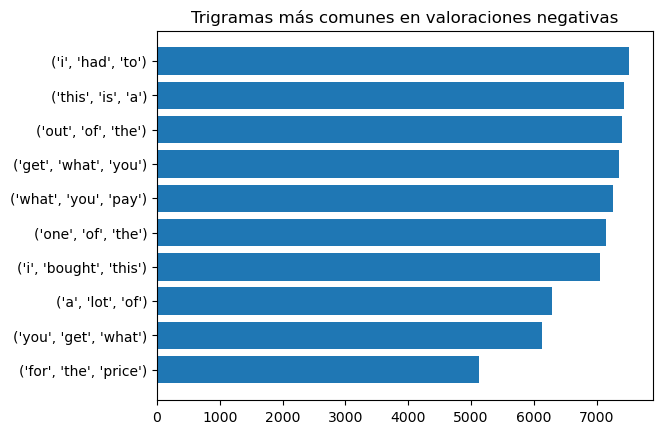

In [46]:
neg_tg_common = neg_tg_freq.most_common(10)
tgs_ = [str(tg[0]) for tg in neg_tg_common]
tgs_f_ = [tg[1] for tg in neg_tg_common]
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

plt.barh(tgs_, tgs_f_)
plt.title('Trigramas más comunes en valoraciones negativas')
plt.show()

... y para valoraciones positivas:

In [47]:
pos_tg_freq.most_common(10)

[(('this', 'is', 'a'), 46169),
 (('for', 'the', 'price'), 29484),
 (('five', 'stars', 'i'), 28147),
 (('five', 'stars', 'great'), 25752),
 (('a', 'lot', 'of'), 25036),
 (('for', 'the', 'price.'), 23239),
 (('is', 'a', 'great'), 23111),
 (('i', 'bought', 'this'), 22382),
 (('it', 'is', 'a'), 19384),
 (('five', 'stars', 'this'), 17135)]

... y para las positivas:

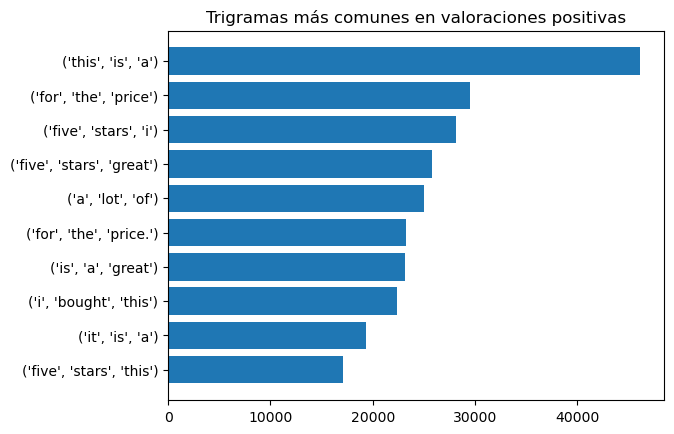

In [48]:
pos_tg_common = pos_tg_freq.most_common(10)
pos_tgs_ = [str(tg[0]) for tg in pos_tg_common]
pos_tgs_f_ = [tg[1] for tg in pos_tg_common]
pos_tgs_f_, pos_tgs_ = zip(*sorted(zip(pos_tgs_f_, pos_tgs_)))

plt.barh(pos_tgs_, pos_tgs_f_)
plt.title('Trigramas más comunes en valoraciones positivas')
plt.show()

Aquí vemos más diferencias entre ambos tipos de sentimiento, pero sutiles. No nos ayuda a entender la sección de productos de la que hablamos, pero sí se ve que se habla de compras, y se ve que hablan de valoración cinco estrellas. Por supuesto, sigue siendo necesario realizar un gran preprocesado de los datos.

#### 4.- Creación de las dos clases de sentimiento··········································································································

Por último, vamos a crear una nueva feature que sea el sentimiento, con sólo dos valores, 0 para negativa y 1 para positiva. Combinaré y convertiré las valoraciones de "overall" con 1,2 y 3 estrellas a la clase 0, y las valoraciones 4 y 5 a la clase 1, y eliminaré la columna "overall".

In [49]:
def mapeo(x):
    if x in [1.,2.,3.]:
        return 0
    else:
        return 1
df_joint["sent"] = df_joint.overall.apply(mapeo)
df_joint = df_joint.drop("overall", axis=1)
df_joint.head(20)

,review,sent
0,"I hesitated at first, but nabbed the kit on a ...",1
1,Plain and simple...some of the frets are not p...,0
2,"she loved it, won't stop playing Five Stars",1
3,Thank you Five Stars,1
4,I ordered this ukulele kit for my granddaughte...,1
5,I bought this as a gift for my husband 2 years...,0
6,Great starter kit! Four Stars,1
7,It's good for beginners Five Stars,1
8,It took longer than expected to be delivered. ...,0
9,The ukulele broke the first time I tuned it. ...,0


Ahora guardaré como .csv el dataframe que contiene la columna de features combinada y la del target para luego procesarla:

In [50]:
df_joint.to_csv("ratings_raw.csv", index=False)